In [149]:
import sqlite3
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [118]:
# Extract data from SQLITE for average monthly rent
conn = sqlite3.connect('rental.sqlite')
df = pd.read_sql_query('''
                        SELECT
                            DATE(CONCAT(rent_approval_date,'-01')) AS month,
                            ROUND(AVG(monthly_rent)) AS overall
                        FROM rental
                        GROUP BY 1
                        ORDER BY 1
                        ''', conn, parse_dates=True)

df.head(10)

,month,overall
0,2021-01-01,2049.0
1,2021-02-01,2048.0
2,2021-03-01,2068.0
3,2021-04-01,2083.0
4,2021-05-01,2104.0
5,2021-06-01,2121.0
6,2021-07-01,2145.0
7,2021-08-01,2136.0
8,2021-09-01,2128.0
9,2021-10-01,2157.0


<Axes: xlabel='month', ylabel='overall'>

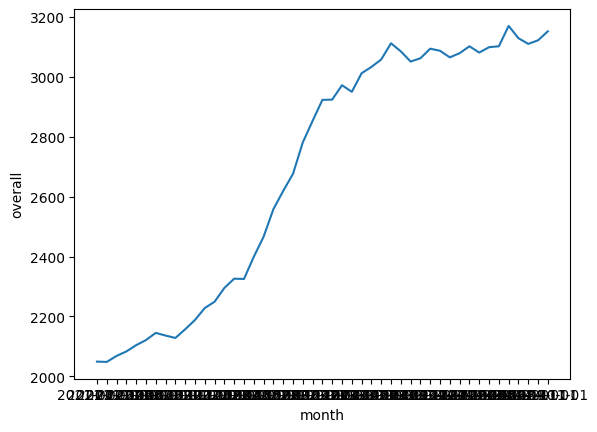

In [119]:
# Plot values to check trend
sns.lineplot(x='month', y='overall', data=df)

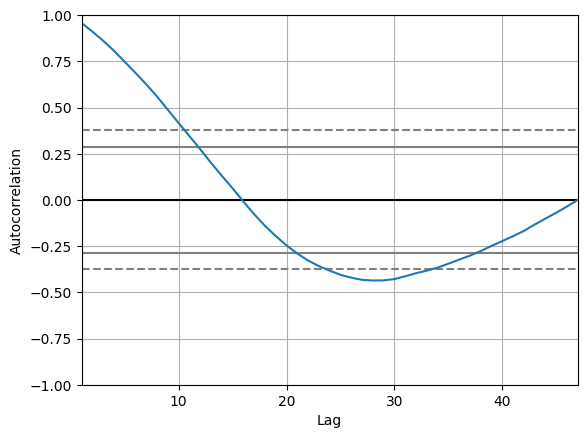

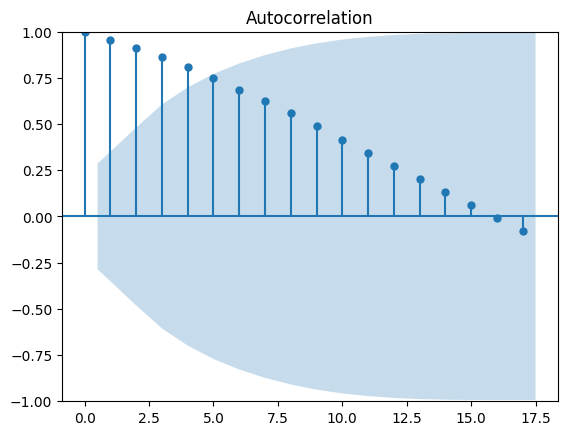

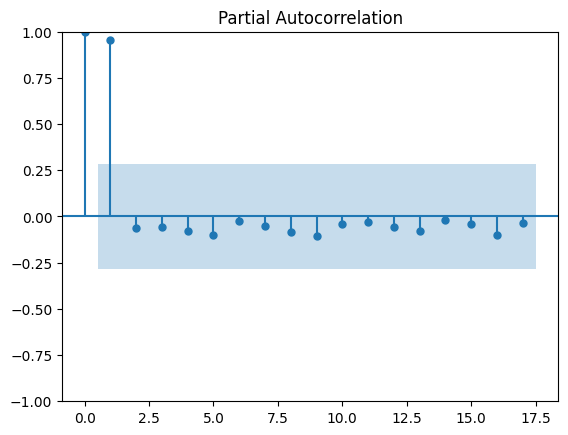

In [121]:
# Check autocorrelation
data = df['overall']
autocorrelation_plot(data)

plot_acf(data)
plt.show()

plot_pacf(data)
plt.show()

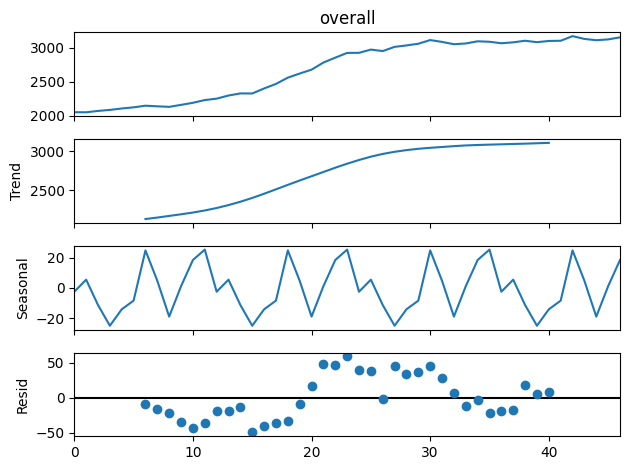

In [150]:
decomposition=seasonal_decompose(data, model='additive', period=12)
decomposition.plot()
plt.show()

In [131]:
# Perform Dicky-Fuller test to check for seasonality
dftest = adfuller(data, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.3657384676374884
2. P-Value :  0.5985869074725195
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 46
5. Critical Values :
	 1% :  -3.5812576580093696
	 5% :  -2.9267849124681518
	 10% :  -2.6015409829867675


In [219]:
data_diff = data.diff(periods=1)
# data_diff = np.log(data)

dftest = adfuller(data_diff.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)


1. ADF :  -2.927180606956924
2. P-Value :  0.04227733388992144
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 44
5. Critical Values :
	 1% :  -3.5885733964124715
	 5% :  -2.929885661157025
	 10% :  -2.6031845661157025


In [178]:
# Test model to find best ARIMA model
model = pmd.auto_arima(data, start_p=1, start_q=1, test='adf', m=12, seasonal=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=461.225, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=446.228, Time=0.01 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=444.247, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=443.443, Time=0.01 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=443.733, Time=0.01 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=445.291, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=445.276, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=450.373, Time=0.00 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=447.160, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=445.441, Time=0.01 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.594 seconds


In [206]:
sarima_test = SARIMAX(data, order=(0,2,1), seasonal_order=(0,0,0,12))
predicted = sarima_test.fit().predict()

predicted


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67744D+00    |proj g|=  8.86303D-03

At iterate    5    f=  4.67509D+00    |proj g|=  8.44643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   9.551D-07   4.675D+00
  F =   4.6749271875077243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0        0.000000
1     3073.542883
2     2048.463220
3     2078.765964
4     2095.425357
5     2119.317967
6     2136.843572
7     2163.294786
8     2146.253027
9     2132.929007
10    2168.914334
11    2205.438670
12    2251.960517
13    2272.105280
14    2324.716921
15    2356.087392
16    2346.112120
17    2435.380771
18    2511.220303
19    2616.725085
20    2678.381824
21    2734.694224
22    2853.062059
23    2925.044143
24    2994.454028
25    2975.114954
26    3022.215711
27    2979.368068
28    3050.788440
29    3066.653172
30    3089.155125
31    3149.750113
32    3104.057682
33    3054.740688
34    3067.836348
35    3107.389420
36    3094.503286
37    3063.986110
38    3082.320405
39    3111.001622
40    3081.340583
41    3104.438604
42    3106.734614
43    3192.998426
44    3133.522996
45    3107.732244
46    3123.851141
Name: predicted_mean, dtype: float64

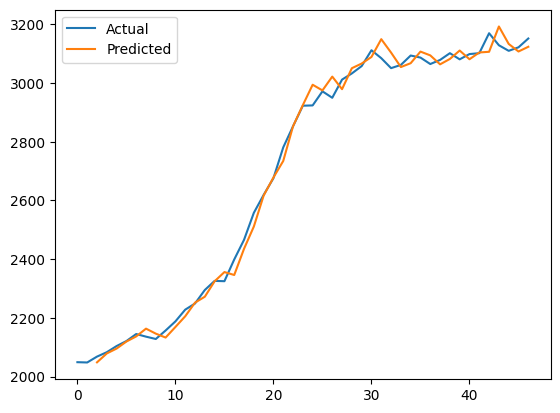

In [209]:
# Check if prediction model works on test data
plt.figure()
plt.plot(data, label='Actual')
plt.plot(predicted.iloc[2:],label='Predicted')
plt.legend()


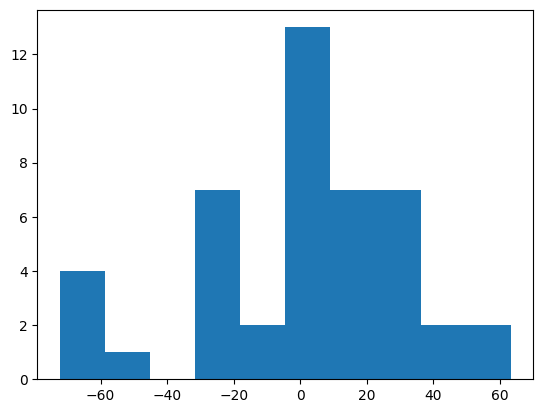

In [181]:
resid = data-predicted.iloc[2:];resid
mae = abs(resid.mean());mae
plt.hist(resid)
plt.show()

In [213]:
pred = model.predict(n_periods=12);pred


47    3161.977314
48    3171.954627
49    3181.931941
50    3191.909255
51    3201.886568
52    3211.863882
53    3221.841196
54    3231.818509
55    3241.795823
56    3251.773136
57    3261.750450
58    3271.727764
dtype: float64

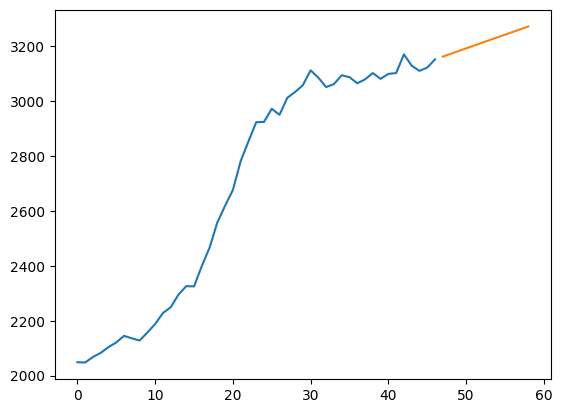

In [191]:
plt.plot(data)
plt.plot(pred)

In [215]:
new_rent = pd.concat([predicted, pred]);new_rent

0        0.000000
1     3073.542883
2     2048.463220
3     2078.765964
4     2095.425357
5     2119.317967
6     2136.843572
7     2163.294786
8     2146.253027
9     2132.929007
10    2168.914334
11    2205.438670
12    2251.960517
13    2272.105280
14    2324.716921
15    2356.087392
16    2346.112120
17    2435.380771
18    2511.220303
19    2616.725085
20    2678.381824
21    2734.694224
22    2853.062059
23    2925.044143
24    2994.454028
25    2975.114954
26    3022.215711
27    2979.368068
28    3050.788440
29    3066.653172
30    3089.155125
31    3149.750113
32    3104.057682
33    3054.740688
34    3067.836348
35    3107.389420
36    3094.503286
37    3063.986110
38    3082.320405
39    3111.001622
40    3081.340583
41    3104.438604
42    3106.734614
43    3192.998426
44    3133.522996
45    3107.732244
46    3123.851141
47    3161.977314
48    3171.954627
49    3181.931941
50    3191.909255
51    3201.886568
52    3211.863882
53    3221.841196
54    3231.818509
55    3241

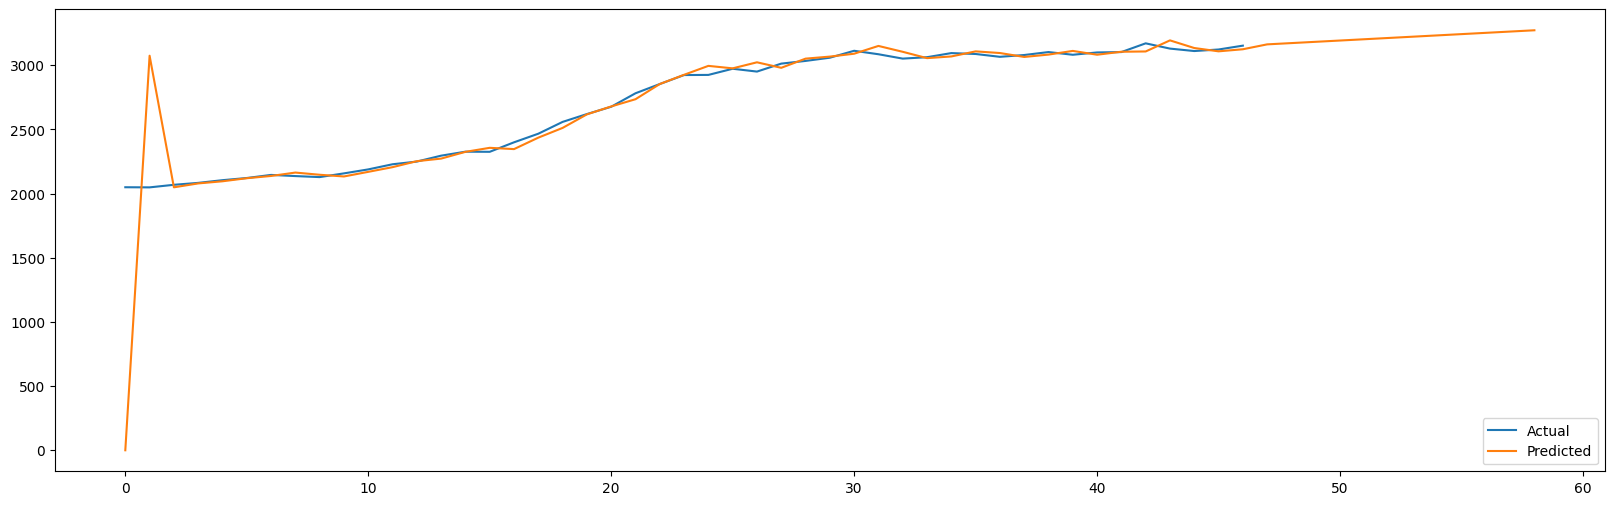

In [216]:
plt.figure(figsize=(20,6))
plt.plot(data, label='Actual')
plt.plot(new_rent, label='Predicted')
plt.legend()